In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

In [159]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 25 * 25, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 25 * 25) # change based on image dimensions?
        x = self.classifier(x)
        return x   

In [125]:
def make_pokedex(path="pokedex/pokemon.csv"):
    pokedex = pd.read_csv(path)
    return pokedex

In [126]:
def pokemon_name_to_number(name):
    pokedex = make_pokedex()
    return pokedex.index[pokedex['Name'] == name].tolist()[0]

In [127]:
def pokemon_number_to_name(number):
    pokedex = make_pokedex()
    return pokedex.iloc[number]['Name']

In [175]:
sprites_number_name = []
for i_pokemon, pokemon in enumerate(os.listdir('samples')):
    for i_img, img in enumerate(os.listdir(os.path.join('samples', pokemon))):
        fp = os.path.join('samples', pokemon, img)
        sprite_image = cv2.imread(fp)
        resized_sprite_image = np.array(cv2.resize(sprite_image, (50, 50)))
        pokemon_number = pokemon_name_to_number(pokemon)
        sprites_number_name.append([resized_sprite_image, pokemon_number, pokemon])
        
# sprites_number_name = np.array(sprites_number_name)
data = pd.DataFrame(sprites_number_name, columns = ['image', 'number', 'name'])

(50, 50, 3)


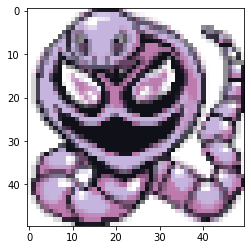

In [129]:
img1 = data.iloc[0]['image']
print(img1.shape)
plt.imshow(img1)
plt.show()

In [184]:
X = data['image']
y = data['number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

tensor_X_train = torch.stack([torch.tensor(img, dtype=torch.float32) for img in data_train['image'].values])
tensor_X_train = torch.transpose(tensor_X_train, 1, 2)
tensor_X_train = torch.transpose(tensor_X_train, 1, 3)
tensor_y_train = torch.tensor(data_train['number'].values)
tensor_train = TensorDataset(tensor_X_train, tensor_y_train)

tensor_X_test = torch.stack([torch.tensor(img, dtype=torch.float32) for img in data_test['image'].values])
tensor_X_test = torch.transpose(tensor_X_test, 1, 2)
tensor_X_test = torch.transpose(tensor_X_test, 1, 3)
tensor_y_test = torch.tensor(data_test['number'].values)
tensor_test = TensorDataset(tensor_X_test, tensor_y_test)


train_loader = DataLoader(tensor_train, batch_size=2, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=2, shuffle=True)

In [171]:
cnn = CNN(num_classes=50)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [188]:
for epoch in range(5):
    running_loss = []
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        pred = cnn(inputs)
        loss = criterion(pred, labels)
        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()
                
    print("Epoch {} loss: {}".format(epoch + 1, np.mean(running_loss)))

print("Done!")   

100%|██████████| 158/158 [00:34<00:00,  4.63it/s]


Epoch 1 loss: nan


100%|██████████| 158/158 [00:35<00:00,  4.40it/s]


Epoch 2 loss: nan


100%|██████████| 158/158 [00:34<00:00,  4.61it/s]


Epoch 3 loss: nan


100%|██████████| 158/158 [00:34<00:00,  4.58it/s]


Epoch 4 loss: nan


100%|██████████| 158/158 [00:31<00:00,  5.02it/s]

Epoch 5 loss: nan
Done!


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        